# Sample workflow LSTM for lumped catchment monthly runoff

This vignette gives an introduction to using the `ozrr` package to define how to train an LTSM model for the simulation of monthly runoff.

It uses an arbitrary catchment and training hyperparameters, for illustrative purposes.

## Imports and logistics

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import os

2023-05-04 10:33:11.642840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from ozrr_data.repository import load_aus_rr_data
from ozrr.tfmodels import CatchmentTraining, checked_mkdir, mk_model_filename

In [3]:
# TODO later: use tensorboard
#  %load_ext tensorboard

Usually, deep learning training is much faster on GPUs, which can be tricky to get to work. 

However, in our particular use case (single catchment) training runs faster on a laptop CPU than a fairly decent GPU, about three times faster, as the parallelism offered by GPUs does not offer advantages. So, we will force the device to be a CPU, anyway.

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.config.set_visible_devices([], "GPU")  # force CPU execution

In [6]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Data ingestion and preparation

The input dataset used in this paper takes the form of multiple comma separated value files. However this section "hides" this detail by using some helper classes and functions to load these into an `xarray` `DataArray`.

`OzrrPathFinder` is not key to this vignette and you can ignore it. 

In [7]:
from ozrr._boilerplate import OzrrPathFinder
pf = OzrrPathFinder()
root_dir_f = pf.find_input_data_dir()

In [8]:
root_dir_out_f = os.path.expanduser("~/data/DWL/out/tftests")
root_dir_out = Path(root_dir_out_f)
if not root_dir_out.exists():
    root_dir_out.mkdir(parents=True)

In [9]:
root_dir = Path(root_dir_f)
out_dir = root_dir_out / "tf_models"

On the first call to `load_aus_rr` it may take around 3 minutes to ingest the hundreds CSV files, if from a local file system. 

However once done, the directory has a netcdf cached entry, and subsequent loading will only take a few seconds, and a fraction of a second with lazy loading.

In [10]:
%%time 
data_repo = load_aus_rr_data(root_dir_f, lazy_loading=True, do_aggregate=False)

CPU times: user 133 ms, sys: 12.2 ms, total: 146 ms
Wall time: 177 ms


In [11]:
data_repo.ds

<xarray.Dataset>
Dimensions:                            (time: 25933, series_id: 11, station: 951)
Coordinates: (12/78)
  * time                               (time) datetime64[ns] 1950-01-01 ... 2...
  * series_id                          (series_id) object 'evap[mm/d]' ... 'r...
  * station                            (station) object '809322' ... '237206'
    lat                                (station) float64 ...
    lon                                (station) float64 ...
    AWRALid                            (station) float64 ...
    ...                                 ...
    runoff_prcnan[%]                   (station) float64 ...
    runoff_ndays                       (station) int64 ...
    runoff_prcinterp[%]                (station) float64 ...
    runoff_nmaxdryspell                (station) int64 ...
    year_month                         (time) object (1950, 1) ... (2020, 12)
    year                               (time) int64 1950 1950 1950 ... 2020 2020
Data variables:
    daily_series                       (station, time, series_id) float64 ...

In [12]:
data_repo.ds.series_id

<xarray.DataArray 'series_id' (series_id: 11)>
array(['evap[mm/d]', 'AWRA_SS[mm]', 'TEMPmax[C]', 'AWRA_S0[mm]', 'TEMPmin[C]',
       'AWRA_ETactual[mm/d]', 'rain[mm/d]', 'AWRA_Runoff[mm/d]',
       'streamflow[ML/d]', 'runoff_linear_flag', 'runoff[mm/d]'], dtype=object)
Coordinates:
  * series_id  (series_id) object 'evap[mm/d]' 'AWRA_SS[mm]' ... 'runoff[mm/d]'

## Seeding

The `ozrr` package includes provision to make sure outcomes are deterministic (broadly speaking by using seeds as argument to tensorflow functions). However, some states in Tensorflow seem to be global, so we also need a static call to `tf.random.set_seed`.

In [13]:
## GLOBAL SEED ##
tf.random.set_seed(123456)
TRAINING_SEED = 42

## Config and Hyperparameters

In [14]:
station_id = "405218"

`CatchmentTraining` is a high level class that deals with setting up the model and data to use for the fitting, hiding the tedium.

In [15]:
model_dir = checked_mkdir(out_dir / "models")
model_file = mk_model_filename(model_dir, station_id, with_timestamp=False)
ct = CatchmentTraining(out_dir, station_id, data_repo, model_file=model_file)

`eval_end_date` is an approximation given the end date of the input climate data set for _most_, but not all catchments.

The data handling module in `ozrr` deals with trailing missing values to find the correct last full month of data prior to that for aggregation, e.g. 2020-06-30, or 2020-05-31.

`ct.conf` is a `CatchmentTrainingConfig` object

In [16]:
ct.conf.eval_end_date = pd.Timestamp("2020-07-15")

In [17]:
ct.conf.stateful = False

ct.fit_verbosity = 0  # https://www.tensorflow.org/api_docs/python/tf/keras/Model
ct.eval_verbosity = 0  # https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Force a reload of the data; we may have changed the time span specifications.
# will be refactored later
# ct.reload_data()
from ozrr.tfmodels import lstm_single

2023-01-30: trying to reproduce some unexpectly disappointing results on a round of batch calibrations.

In [18]:
ct.conf.n_epochs=100
ct.conf.train_start_date=pd.Timestamp("1950-01-01")
ct.conf.train_end_date=pd.Timestamp("1995-12-31")
ct.conf.eval_start_date=pd.Timestamp("1996-01-01")
ct.conf.eval_end_date=pd.Timestamp("2020-07-15")
ct.conf.batch_size=24
ct.conf.seq_length=6
ct.conf.num_features=3
ct.conf.feature_ids=["rain", "pet", "eff_rain"]
ct.conf.steps_per_epoch=100
ct.conf.shuffle=True
ct.conf.stride=1
ct.conf.lstm_dim=10
ct.conf.logging="false" # false (default), tensorboard, wandb
ct.conf.log_dir="ignored" # directory for log output
ct.conf.use_validation=False # Should there be a training/validation split of the calibration period as a strategy to prevent model overfitting. 
ct.conf.early_stopping=False
ct.conf.early_stopping_patience=14
ct.conf.lr_patience=3
ct.conf.lr_factor=0.5
ct.conf.lr_start=0.05
ct.conf.dropout=0.1
ct.conf.recurrent_dropout=0.1

`model_func` needs to be reset AFTER the settings above. This will trigger the creation of the model with newer parameters. This is a design compromise resulting from legacy.

In [19]:
ct.conf.model_func = "lstm_single"

In [20]:
# ds = data_repo.data_for_station(station_id)

A data object holds the observations aggregated to monthly, and their scaled version

In [27]:
x = ct.scaled_training_data()

In [28]:
x.x

,rain,pet,eff_rain
t,,,
1959-03-31,-0.532426,0.385026,-0.694146
1959-04-30,-0.353701,-0.483118,-0.176882
1959-05-31,-1.363860,-0.914580,-1.096170
1959-06-30,-0.063804,-1.247830,0.144238
1959-07-31,-0.692425,-1.207809,-0.478399
...,...,...,...
1995-08-31,-0.734161,-0.792916,-0.617635
1995-09-30,-0.598107,-0.459398,-0.619684
1995-10-31,0.358981,0.254840,0.339624


In [29]:
if model_file.exists(): model_file.unlink()

In [30]:
import tensorflow as tf
import logging

# Set the verbosity level to 'WARNING' or 'ERROR' to suppress the output
tf.get_logger().setLevel(logging.WARNING)


In [31]:
%%time 
result = ct.train(random_seed=TRAINING_SEED)

2023-05-04 10:36:29.324729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 45.5 s, sys: 2.89 s, total: 48.4 s
Wall time: 21 s


In [32]:
ct.training_result.params

{'verbose': 0, 'epochs': 100, 'steps': 100}

In [33]:
_ = ct.evaluate()

288/288 [==============================] - 0s 647us/step


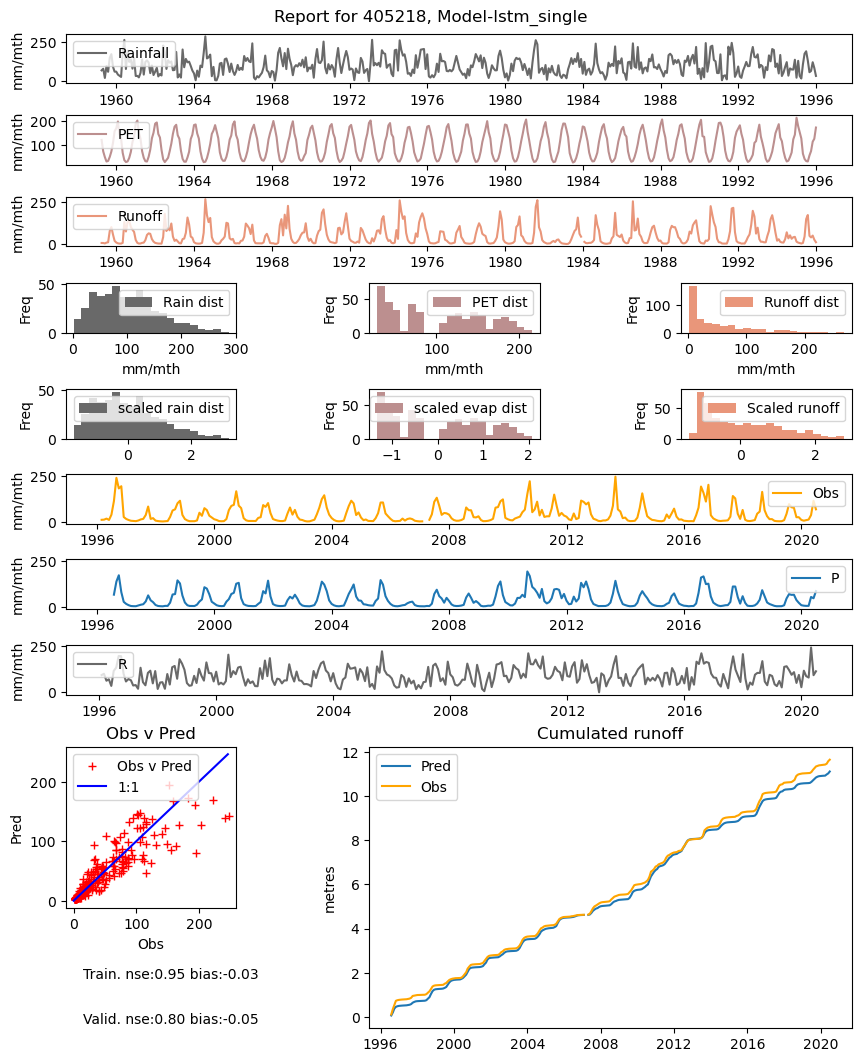

In [34]:
# save predictions
ct.save_verif_report = False
ct.generate_report()